# Including new observational data

In this tutorial we will see how to load observational data onto IMAGINE. 

Both observational and simulated data are manipulated within IMAGINE through *observable dictionaries*. There are three types of these: `Measurements`, `Simulations` and `Covariances`, which can store multiple entries of observational, simulated and covariance (either real or mock) data, respectively. Appending data to an `ObservableDict` requires following some requirements regarding the data format, therefore we recomend the use of one of the `Dataset` classes.


## HEALPix Datasets 

Let us illustrate how to prepare an IMAGINE dataset with the Faraday depth map obtained by Oppermann et al. 2012 ([arXiv:1111.6186](https://arxiv.org/abs/1111.6186)). 

The following snippet will download the [data](https://wwwmpa.mpa-garching.mpg.de/ift/faraday/2012/index.html) (a ~4MB FITS file) to RAM and open it.

In [1]:
import requests, io
from astropy.io import fits

download = requests.get('https://wwwmpa.mpa-garching.mpg.de/ift/faraday/2012/faraday.fits')
raw_dataset = fits.open(io.BytesIO(download.content))
raw_dataset.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  TEMPERATURE    1 BinTableHDU     17   196608R x 1C   [E]   
  2  signal uncertainty    1 BinTableHDU     17   196608R x 1C   [E]   
  3  Faraday depth    1 BinTableHDU     17   196608R x 1C   [E]   
  4  Faraday uncertainty    1 BinTableHDU     17   196608R x 1C   [E]   
  5  galactic profile    1 BinTableHDU     17   196608R x 1C   [E]   
  6  angular power spectrum of signal    1 BinTableHDU     12   384R x 1C   [E]   


Now we will feed this to an IMAGINE `Dataset`. It requires 
converting the data into a proper numpy array of floats. 
To allow this notebook running on a small memory laptop, we
will also reduce the size of the arrays (only taking 1 value every 256).

In [2]:
from imagine.observables import FaradayDepthHEALPixDataset
import numpy as np
from astropy import units as u
import healpy as hp

# Adjusts the data to the right format
fd_raw = raw_dataset[3].data.astype(np.float)
sigma_fd_raw = raw_dataset[4].data.astype(np.float)
# Makes it smaller, to save memory
fd_raw = hp.pixelfunc.ud_grade(fd_raw, 4)
sigma_fd_raw = hp.pixelfunc.ud_grade(sigma_fd_raw, 4)
# We need to include units the data
# (this avoids later errors and inconsistencies)
fd_raw *= u.rad/u.m/u.m
sigma_fd_raw *= u.rad/u.m/u.m
# Loads into a Dataset
dset = FaradayDepthHEALPixDataset(data=fd_raw, error=sigma_fd_raw)

One important assumption in the previous code-block is that the covariance matrix is diagonal, i.e. that the errors in FD are *uncorrelated*. 
If this is not
the case, instead of initializing the `FaradayDepthHEALPixDataset` with `data` and `error`, one should initialize it with `data` and `cov`, where the latter
is the correct covariance matrix.

To keep things organised and useful, we *strongly recommend* to create a 
personalised `dataset` class and make it available to the rest of the
consortium in the [imagine-datasets](https://github.com/IMAGINE-Consortium/imagine-datasets) GitHub repository. 
An example of such a class is the following:

In [3]:
from imagine.observables import FaradayDepthHEALPixDataset

class FaradayDepthOppermann2012(FaradayDepthHEALPixDataset):
    def __init__(self, Nside=None):
        # Fetches and reads the 
        download = requests.get('https://wwwmpa.mpa-garching.mpg.de/ift/faraday/2012/faraday.fits')
        raw_dataset = fits.open(io.BytesIO(download.content))
        # Adjusts the data to the right format
        fd_raw = raw_dataset[3].data.astype(np.float)
        sigma_fd_raw = raw_dataset[4].data.astype(np.float)
        # Reduces the resolution
        if Nside is not None:
            fd_raw = hp.pixelfunc.ud_grade(fd_raw, Nside)
            sigma_fd_raw = hp.pixelfunc.ud_grade(sigma_fd_raw, Nside)
        # Includes units in the data
        fd_raw *= u.rad/u.m/u.m
        sigma_fd_raw *= u.rad/u.m/u.m
        # Loads into the Dataset
        super().__init__(data=fd_raw, error=sigma_fd_raw)

With this pre-programmed, anyone will be able to load this into the pipeline by simply doing

In [4]:
dset = FaradayDepthOppermann2012()

Once we have a dataset, we can load this into a Measurements and Covariances objects (which will be discussed a further down).

In [5]:
from imagine.observables import Measurements, Covariances

# Creates the instances
mea = Measurements()

# Appends the data
mea.append(dataset=dset)

If the dataset contains error or covariance data, its inclusion in a `Measurements` object  automatically leads to the inclusion of such dataset in an associated `Covariances` object. This can be accessed through the `cov` attribute:

In [6]:
mea.cov

An alternative, rather useful, supported syntax is providing the datasets as one initializes the `Measurements` object.

In [7]:
# Creates _and_ appends
mea = Measurements(dset)

## Tabular Datasets 

So far, we looked into datasets comprising [HEALPix](https://healpix.sourceforge.io/) maps. One may also want to
work with *tabular* datasets.  We exemplify this fetching and preparing a RM
catalogue of Mao et al 2010 ([arXiv:1003.4519](https://arxiv.org/abs/1003.4519)). 
In the case of this particular dataset, we can import the data from VizieR using the `astroquery` library.

In [8]:
import astroquery
from astroquery.vizier import Vizier

# Fetches the relevant catalogue from Vizier
# (see https://astroquery.readthedocs.io/en/latest/vizier/vizier.html for details)
catalog = Vizier.get_catalogs('J/ApJ/714/1170')[0]
catalog[:3] # Shows only first rows

RAJ2000,DEJ2000,GLON,GLAT,RM,e_RM,PI,I,S5.2,f_S5.2,NVSS
"""h:m:s""","""d:m:s""",deg,deg,rad / m2,rad / m2,mJy,mJy,,,
bytes11,bytes11,float32,float32,int16,int16,float32,float64,bytes3,bytes1,bytes4
13 07 08.33,+24 47 00.7,0.21,85.76,-3,4,7.77,131.49,Yes,,NVSS
13 35 48.14,+20 10 16.0,0.86,77.70,3,5,8.72,71.47,No,b,NVSS
13 24 14.48,+22 13 13.1,1.33,81.08,-6,6,7.62,148.72,Yes,,NVSS


The procedure for converting this to an IMAGINE data set is the following:

In [9]:
from imagine.observables import TabularDataset
dset_tab = TabularDataset(catalog, name='fd', tag=None,
                          units= u.rad/u.m/u.m,
                          data_col='RM', err_col='e_RM', 
                          lat_col='GLAT', lon_col='GLON')

`catalog` must be a dictionary-like object (e.g. `dict`, `astropy.Tables`, `pandas.DataFrame`) and data(/error/lat/lon)\_column specify the key/column-name used to retrieve the relevant data from `catalog`.  The `name` argument specifies the type of measurement that is being stored. This has to agree with the requirements of the Simulator you will use. Some standard available observable names are:

* 'fd' - Faraday depth
* 'sync' - Synchrotron emission, needs the `tag` to be interpreted
    * tag = 'I' - Total intensity
    * tag = 'Q' - Stokes Q
    * tag = 'U' - Stokes U
    * tag = 'PI' - polarisation intensity 
    * tag = 'PA' - polarisation angle
* 'dm' - Dispersion measure

The units are provided as an `astropy.units.Unit` object and are converted internally to the requirements of the specific Simulator being used.

Again, the procedure can be packed and distributed to the community in a (very short!) personalised class:

In [10]:
from astroquery.vizier import Vizier
from imagine.observables import TabularDataset

class FaradayRotationMao2010(TabularDataset):
    def __init__(self):
        # Fetches the catalogue
        catalog = Vizier.get_catalogs('J/ApJ/714/1170')[0]
        # Reads it to the TabularDataset (the catalogue obj actually contains units)
        super().__init__(catalog, name='fd', units=catalog['RM'].unit,
                         data_col='RM', err_col='e_RM', 
                         lat_col='GLAT', lon_col='GLON')

In [11]:
dset_tab = FaradayRotationMao2010() # ta-da!

## Measurements and Covariances

Again, we can include these observables in our `Measurements` object. This is a dictionary-like object, i.e. given a key, one can access a given item.

In [12]:
mea.append(dataset=dset_tab)

print('Measurement keys:')
for k in mea.keys():
    print('\t',k)

Measurement keys:
	 ('fd', None, 128, None)
	 ('fd', None, 'tab', None)


Associated with the `Measurements` objects there is a `Covariances` object which stores the covariance matrix associated with each entry in the `Measurements`. This is also an `ObservableDict` subclass and has, therefore, similar behaviour. If the original `Dataset` contained error information but no full covariance data, a diagonal covariance matrix is assumed. (N.B. correlations between different observables -- i.e. different entries in the `Measurements` object -- are still not supported.)

In [13]:
print('Covariances dictionary', mea.cov)
print('\nCovariance keys:')
for k in mea.cov.keys():
    print('\t',k)

Covariances dictionary <imagine.observables.observable_dict.Covariances object at 0x7f07ba999450>

Covariance keys:
	 ('fd', None, 128, None)
	 ('fd', None, 'tab', None)


The keys follow a strict convention:
``(data-name,data-freq,Nside/'tab',ext)``

* If data is independent from frequency, data-freq is set `None`, otherwise it is the frequency in GHz.
* The third value in the key-tuple is the HEALPix Nside (for maps) or the string 'tab' for tabular data. 
* Finally, the last value, `ext` can be 'I','Q','U','PI','PA', None or other customized tags depending on the nature of the observable.

### Accessing and visualising data

Frequently, one may want to see what is inside a given Measurements object.
For this, one can use the handy helper method `show()`

/home/lfsr/.local/lib/python3.7/site-packages/healpy-1.12.8-py3.7-linux-x86_64.egg/healpy/projaxes.py:989: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/lfsr/.local/lib/python3.7/site-packages/healpy-1.12.8-py3.7-linux-x86_64.egg/healpy/projaxes.py:959: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


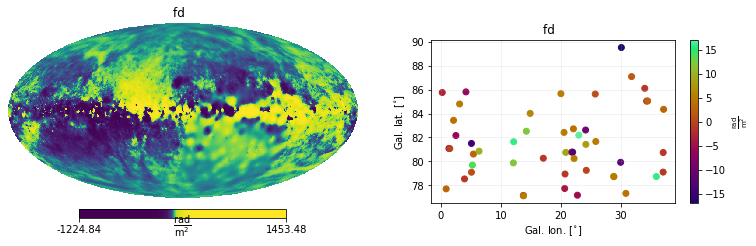

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))

mea.show()

this method will show all the contents of your `Measurements` object. 

To directly access the data, one needs first to find out what the keys are:

In [15]:
list(mea.keys())

[('fd', None, 128, None), ('fd', None, 'tab', None)]

and use them to get the data using the `global_data` property

In [16]:
extracted_obs_data = mea[('fd', None, 128, None)].global_data
print(type(extracted_obs_data))
print(extracted_obs_data.shape)

<class 'numpy.ndarray'>
(1, 196608)


### Manually including data

An alternative way to include data into an Observables dictionary is explicitly choosing the key and adjusting the data shape. One can see how this is handled by the Dataset object in the following cell

In [17]:
# Creates a new dataset
dset = FaradayDepthOppermann2012(Nside=64)
# This is how HEALPix data can be included without the mediation of Datasets:
mea.append(name=dset.key, data=dset.data, otype='HEALPix',
           cov_data=dset.cov, cov_unit=dset.cov_unit)
# This is what Dataset is doing:
print('The key used in the "name" arg was:', dset.key)
print('The shape of data was:', dset.data.shape)
print('The shape of the covariance matrix arg was:', dset.cov.data.shape)

The key used in the "name" arg was: ('fd', None, 64, None)
The shape of data was: (1, 49152)
The shape of the covariance matrix arg was: (49152,)


But what exactly is stored in `mea`?  This is handled by an `Observable` object.
Here we illustrate with the tabular dataset previously defined.

In [18]:
print(type(mea[dset_tab.key]))
print('mea.data:', repr(mea[dset_tab.key].data))
print('mea.data.shape:', mea[dset_tab.key].data.shape)
print('mea.unit', repr(mea[dset_tab.key].unit))
print('mea.coords (coordinates dict -- for tabular datasets only):\n', 
      mea[dset_tab.key].coords)
print('mea.dtype:', mea[dset_tab.key].dtype)
print('mea.otype:', mea[dset_tab.key].otype)
print('\n\nmea.cov type',type(mea.cov[dset_tab.key]))
print('mea.cov.data type:', type(mea.cov[dset_tab.key].data))
print('mea.cov.data.shape:', mea.cov[dset_tab.key].data.shape)
print('mea.cov.dtype:', mea.cov[dset_tab.key].dtype)

<class 'imagine.observables.observable.Observable'>
mea.data: array([[ -3.,   3.,  -6.,   0.,   4.,  -6.,   5.,  -1.,  -6.,   1., -14.,
         14.,   3.,  10.,  12.,  16.,  -3.,   5.,  12.,   6.,  -1.,   5.,
          5.,  -4.,  -1.,   9.,  -1., -13.,   4.,   5.,  -5.,  17., -10.,
          8.,   0.,   1.,   5.,   9.,   5., -12., -17.,   4.,   2.,  -1.,
         -3.,   3.,  16.,  -1.,  -1.,   3.]])
mea.data.shape: (1, 50)
mea.unit Unit("rad / m2")
mea.coords (coordinates dict -- for tabular datasets only):
 {'type': 'galactic', 'lon': <Quantity [ 0.21,  0.86,  1.33,  1.47,  2.1 ,  2.49,  3.11,  3.93,  4.17,
            5.09,  5.09,  5.25,  5.42,  6.36, 12.09, 12.14, 13.76, 13.79,
           14.26, 14.9 , 17.1 , 20.04, 20.56, 20.67, 20.73, 20.85, 21.83,
           22.  , 22.13, 22.24, 22.8 , 23.03, 24.17, 24.21, 24.28, 25.78,
           25.87, 28.84, 28.9 , 30.02, 30.14, 30.9 , 31.85, 34.05, 34.37,
           34.54, 35.99, 37.12, 37.13, 37.2 ] deg>, 'lat': <Quantity [85.76, 77.7 , 81.

The `Dataset` object may also automatically distribute the data across different nodes if one is running the code using MPI parallelisation 
-- a strong reason for sticking to using `Datasets` instead of appending directly.